In [31]:
import os
import numpy as np
from matplotlib import pyplot as plt
import rasterio
import json
from pprint import pprint
from scipy.misc import bytescale

%matplotlib inline
# from earthpy import spatial as es

In [2]:
def plot_rgb(arr, vmin=0, vmax=255, extent=None):
    
    if arr.shape[-1] != 3:
        raise Exception('Input needs to be 3 band, and band channel needs to be last channel')
        
    if type(arr) is np.ma.MaskedArray:
        # build alpha channel        
        mask = np.ma.getmask(arr[:,:,0])
        mask = ~mask * 255
        
        # add the mask to the array (ise earthpy bytescale)
        plot_arr = np.dstack((bytescale(arr),mask))
        
        # plot it
        plt.imshow(plot_arr, vmin=vmin, vmax=vmax, extent=extent)
        plt.show()
        
    else: #no mask, no worries
        plt.imshow(bytescale(arr))
        
    return None

In [3]:
## we will pick a scene over the front range. Check out the files in the folder on AWS
#aws_scene_path = 'landsat-pds/c1/L8/034/032/LC08_L1TP_034032_20180611_20180615_01_T1'
aws_scene_path = 'landsat-pds/c1/L8/034/032/LC08_L1TP_034032_20180526_20180605_01_T1'
!aws s3 ls $aws_scene_path/ --no-sign-request

2018-06-05 23:05:07     117266 LC08_L1TP_034032_20180526_20180605_01_T1_ANG.txt
2018-06-05 23:04:50   64543762 LC08_L1TP_034032_20180526_20180605_01_T1_B1.TIF
2018-06-05 23:04:52    8291279 LC08_L1TP_034032_20180526_20180605_01_T1_B1.TIF.ovr
2018-06-05 23:04:37   58906434 LC08_L1TP_034032_20180526_20180605_01_T1_B10.TIF
2018-06-05 23:04:52    8326690 LC08_L1TP_034032_20180526_20180605_01_T1_B10.TIF.ovr
2018-06-05 23:04:36      11605 LC08_L1TP_034032_20180526_20180605_01_T1_B10_wrk.IMD
2018-06-05 23:04:54   57516650 LC08_L1TP_034032_20180526_20180605_01_T1_B11.TIF
2018-06-05 23:04:41    8174375 LC08_L1TP_034032_20180526_20180605_01_T1_B11.TIF.ovr
2018-06-05 23:04:42      11605 LC08_L1TP_034032_20180526_20180605_01_T1_B11_wrk.IMD
2018-06-05 23:04:36      11605 LC08_L1TP_034032_20180526_20180605_01_T1_B1_wrk.IMD
2018-06-05 23:05:06   65529406 LC08_L1TP_034032_20180526_20180605_01_T1_B2.TIF
2018-06-05 23:04:56    8405569 LC08_L1TP_034032_20180526_20180605_01_T1_B2.TIF.ovr
2018-06-05 23:04:

# since we don't have AWSCLI configured, we will need to download the data before we can load it.

In [4]:
scene_base = os.path.basename(aws_scene_path) # all after last slash
bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7'] # need these for the file paths

# specify an output directory to hold the files. create it if it doesn't exist
L8_dir = 'data_L8'
if not os.path.exists(L8_dir):
    os.mkdir(L8_dir)

# iterate through the bands list to download the data
for band in bands:
    sample_band = aws_scene_path + '/{}_{}.TIF'.format(scene_base, band)
    s3_path = "s3://{}".format(sample_band)
    print(s3_path)
    
    # copy from S3 if not done already
    if not os.path.exists(L8_dir + '/{}_{}.TIF'.format(scene_base, band)):
        !aws s3 cp $s3_path $L8_dir --no-sign-request
    

s3://landsat-pds/c1/L8/034/032/LC08_L1TP_034032_20180526_20180605_01_T1/LC08_L1TP_034032_20180526_20180605_01_T1_B1.TIF
Completed 256.0 KiB/61.6 MiB (229.8 KiB/s) with 1 file(s) remaining
Completed 512.0 KiB/61.6 MiB (437.6 KiB/s) with 1 file(s) remaining
Completed 768.0 KiB/61.6 MiB (640.0 KiB/s) with 1 file(s) remaining
Completed 1.0 MiB/61.6 MiB (844.9 KiB/s) with 1 file(s) remaining  
Completed 1.2 MiB/61.6 MiB (1006.3 KiB/s) with 1 file(s) remaining 
Completed 1.5 MiB/61.6 MiB (1.2 MiB/s) with 1 file(s) remaining    
Completed 1.8 MiB/61.6 MiB (1.3 MiB/s) with 1 file(s) remaining    
Completed 2.0 MiB/61.6 MiB (1.4 MiB/s) with 1 file(s) remaining    
Completed 2.2 MiB/61.6 MiB (1.6 MiB/s) with 1 file(s) remaining    
Completed 2.5 MiB/61.6 MiB (1.7 MiB/s) with 1 file(s) remaining    
Completed 2.8 MiB/61.6 MiB (1.9 MiB/s) with 1 file(s) remaining    
Completed 3.0 MiB/61.6 MiB (2.0 MiB/s) with 1 file(s) remaining    
Completed 3.2 MiB/61.6 MiB (2.1 MiB/s) with 1 file(s) remaining 

Completed 256.0 KiB/62.5 MiB (301.5 KiB/s) with 1 file(s) remaining
Completed 512.0 KiB/62.5 MiB (558.3 KiB/s) with 1 file(s) remaining
Completed 768.0 KiB/62.5 MiB (831.2 KiB/s) with 1 file(s) remaining
Completed 1.0 MiB/62.5 MiB (1.1 MiB/s) with 1 file(s) remaining    
Completed 1.2 MiB/62.5 MiB (1.2 MiB/s) with 1 file(s) remaining    
Completed 1.5 MiB/62.5 MiB (1.5 MiB/s) with 1 file(s) remaining    
Completed 1.8 MiB/62.5 MiB (1.7 MiB/s) with 1 file(s) remaining    
Completed 2.0 MiB/62.5 MiB (1.9 MiB/s) with 1 file(s) remaining    
Completed 2.2 MiB/62.5 MiB (2.1 MiB/s) with 1 file(s) remaining    
Completed 2.5 MiB/62.5 MiB (2.1 MiB/s) with 1 file(s) remaining    
Completed 2.8 MiB/62.5 MiB (2.2 MiB/s) with 1 file(s) remaining    
Completed 3.0 MiB/62.5 MiB (2.4 MiB/s) with 1 file(s) remaining    
Completed 3.2 MiB/62.5 MiB (2.5 MiB/s) with 1 file(s) remaining    
Completed 3.5 MiB/62.5 MiB (2.6 MiB/s) with 1 file(s) remaining    
Completed 3.8 MiB/62.5 MiB (2.7 MiB/s) with 1 fi

Completed 256.0 KiB/63.5 MiB (289.6 KiB/s) with 1 file(s) remaining
Completed 512.0 KiB/63.5 MiB (543.5 KiB/s) with 1 file(s) remaining
Completed 768.0 KiB/63.5 MiB (812.7 KiB/s) with 1 file(s) remaining
Completed 1.0 MiB/63.5 MiB (1.0 MiB/s) with 1 file(s) remaining    
Completed 1.2 MiB/63.5 MiB (1.2 MiB/s) with 1 file(s) remaining    
Completed 1.5 MiB/63.5 MiB (1.5 MiB/s) with 1 file(s) remaining    
Completed 1.8 MiB/63.5 MiB (1.7 MiB/s) with 1 file(s) remaining    
Completed 2.0 MiB/63.5 MiB (1.8 MiB/s) with 1 file(s) remaining    
Completed 2.2 MiB/63.5 MiB (2.1 MiB/s) with 1 file(s) remaining    
Completed 2.5 MiB/63.5 MiB (2.0 MiB/s) with 1 file(s) remaining    
Completed 2.8 MiB/63.5 MiB (2.2 MiB/s) with 1 file(s) remaining    
Completed 3.0 MiB/63.5 MiB (2.4 MiB/s) with 1 file(s) remaining    
Completed 3.2 MiB/63.5 MiB (2.5 MiB/s) with 1 file(s) remaining    
Completed 3.5 MiB/63.5 MiB (2.7 MiB/s) with 1 file(s) remaining    
Completed 3.8 MiB/63.5 MiB (2.7 MiB/s) with 1 fi

Completed 256.0 KiB/65.2 MiB (295.6 KiB/s) with 1 file(s) remaining
Completed 512.0 KiB/65.2 MiB (553.5 KiB/s) with 1 file(s) remaining
Completed 768.0 KiB/65.2 MiB (821.4 KiB/s) with 1 file(s) remaining
Completed 1.0 MiB/65.2 MiB (1.1 MiB/s) with 1 file(s) remaining    
Completed 1.2 MiB/65.2 MiB (1.2 MiB/s) with 1 file(s) remaining    
Completed 1.5 MiB/65.2 MiB (1.4 MiB/s) with 1 file(s) remaining    
Completed 1.8 MiB/65.2 MiB (1.6 MiB/s) with 1 file(s) remaining    
Completed 2.0 MiB/65.2 MiB (1.7 MiB/s) with 1 file(s) remaining    
Completed 2.2 MiB/65.2 MiB (1.9 MiB/s) with 1 file(s) remaining    
Completed 2.5 MiB/65.2 MiB (2.2 MiB/s) with 1 file(s) remaining    
Completed 2.8 MiB/65.2 MiB (2.1 MiB/s) with 1 file(s) remaining    
Completed 3.0 MiB/65.2 MiB (2.2 MiB/s) with 1 file(s) remaining    
Completed 3.2 MiB/65.2 MiB (2.4 MiB/s) with 1 file(s) remaining    
Completed 3.5 MiB/65.2 MiB (2.5 MiB/s) with 1 file(s) remaining    
Completed 3.8 MiB/65.2 MiB (2.7 MiB/s) with 1 fi

Completed 256.0 KiB/66.7 MiB (274.1 KiB/s) with 1 file(s) remaining
Completed 512.0 KiB/66.7 MiB (532.8 KiB/s) with 1 file(s) remaining
Completed 768.0 KiB/66.7 MiB (794.2 KiB/s) with 1 file(s) remaining
Completed 1.0 MiB/66.7 MiB (1011.9 KiB/s) with 1 file(s) remaining 
Completed 1.2 MiB/66.7 MiB (1.2 MiB/s) with 1 file(s) remaining    
Completed 1.5 MiB/66.7 MiB (1.4 MiB/s) with 1 file(s) remaining    
Completed 1.8 MiB/66.7 MiB (1.7 MiB/s) with 1 file(s) remaining    
Completed 2.0 MiB/66.7 MiB (1.9 MiB/s) with 1 file(s) remaining    
Completed 2.2 MiB/66.7 MiB (1.8 MiB/s) with 1 file(s) remaining    
Completed 2.5 MiB/66.7 MiB (2.0 MiB/s) with 1 file(s) remaining    
Completed 2.8 MiB/66.7 MiB (2.2 MiB/s) with 1 file(s) remaining    
Completed 3.0 MiB/66.7 MiB (2.3 MiB/s) with 1 file(s) remaining    
Completed 3.2 MiB/66.7 MiB (2.4 MiB/s) with 1 file(s) remaining    
Completed 3.5 MiB/66.7 MiB (2.5 MiB/s) with 1 file(s) remaining    
Completed 3.8 MiB/66.7 MiB (2.7 MiB/s) with 1 fi

Completed 256.0 KiB/67.2 MiB (286.7 KiB/s) with 1 file(s) remaining
Completed 512.0 KiB/67.2 MiB (535.6 KiB/s) with 1 file(s) remaining
Completed 768.0 KiB/67.2 MiB (790.1 KiB/s) with 1 file(s) remaining
Completed 1.0 MiB/67.2 MiB (986.5 KiB/s) with 1 file(s) remaining  
Completed 1.2 MiB/67.2 MiB (1.1 MiB/s) with 1 file(s) remaining    
Completed 1.5 MiB/67.2 MiB (1.4 MiB/s) with 1 file(s) remaining    
Completed 1.8 MiB/67.2 MiB (1.5 MiB/s) with 1 file(s) remaining    
Completed 2.0 MiB/67.2 MiB (1.7 MiB/s) with 1 file(s) remaining    
Completed 2.2 MiB/67.2 MiB (1.9 MiB/s) with 1 file(s) remaining    
Completed 2.5 MiB/67.2 MiB (2.1 MiB/s) with 1 file(s) remaining    
Completed 2.8 MiB/67.2 MiB (2.2 MiB/s) with 1 file(s) remaining    
Completed 3.0 MiB/67.2 MiB (2.3 MiB/s) with 1 file(s) remaining    
Completed 3.2 MiB/67.2 MiB (2.3 MiB/s) with 1 file(s) remaining    
Completed 3.5 MiB/67.2 MiB (2.5 MiB/s) with 1 file(s) remaining    
Completed 3.8 MiB/67.2 MiB (2.6 MiB/s) with 1 fi

Completed 256.0 KiB/66.5 MiB (283.8 KiB/s) with 1 file(s) remaining
Completed 512.0 KiB/66.5 MiB (561.4 KiB/s) with 1 file(s) remaining
Completed 768.0 KiB/66.5 MiB (811.8 KiB/s) with 1 file(s) remaining
Completed 1.0 MiB/66.5 MiB (1.0 MiB/s) with 1 file(s) remaining    
Completed 1.2 MiB/66.5 MiB (1.3 MiB/s) with 1 file(s) remaining    
Completed 1.5 MiB/66.5 MiB (1.5 MiB/s) with 1 file(s) remaining    
Completed 1.8 MiB/66.5 MiB (1.7 MiB/s) with 1 file(s) remaining    
Completed 2.0 MiB/66.5 MiB (1.9 MiB/s) with 1 file(s) remaining    
Completed 2.2 MiB/66.5 MiB (1.9 MiB/s) with 1 file(s) remaining    
Completed 2.5 MiB/66.5 MiB (2.0 MiB/s) with 1 file(s) remaining    
Completed 2.8 MiB/66.5 MiB (2.2 MiB/s) with 1 file(s) remaining    
Completed 3.0 MiB/66.5 MiB (2.3 MiB/s) with 1 file(s) remaining    
Completed 3.2 MiB/66.5 MiB (2.5 MiB/s) with 1 file(s) remaining    
Completed 3.5 MiB/66.5 MiB (2.7 MiB/s) with 1 file(s) remaining    
Completed 3.8 MiB/66.5 MiB (2.9 MiB/s) with 1 fi

# also get the json file, to view the metadata

In [5]:
# download the JSON file if it doesn't exist already
json_path = 's3://' + aws_scene_path + '/{}_MTL.json'.format(scene_base)

if not os.path.exists(L8_dir + '/{}_MTL.json'.format(scene_base)):
    !aws s3 cp $json_path $L8_dir --no-sign-request

Completed 10.3 KiB/10.3 KiB (31.3 KiB/s) with 1 file(s) remaining
download: s3://landsat-pds/c1/L8/034/032/LC08_L1TP_034032_20180526_20180605_01_T1/LC08_L1TP_034032_20180526_20180605_01_T1_MTL.json to data_L8\LC08_L1TP_034032_20180526_20180605_01_T1_MTL.json


In [6]:
# load the file
local_mtl = L8_dir + '/{}_MTL.json'.format(scene_base)

with open(local_mtl, 'r') as f:
    mtl = json.load(f)
    
# show it with pretty print    
pprint(mtl)

{'L1_METADATA_FILE': {'IMAGE_ATTRIBUTES': {'CLOUD_COVER': 3.36,
                                           'CLOUD_COVER_LAND': 3.36,
                                           'EARTH_SUN_DISTANCE': 1.0130559,
                                           'GEOMETRIC_RMSE_MODEL': 7.082,
                                           'GEOMETRIC_RMSE_MODEL_X': 4.869,
                                           'GEOMETRIC_RMSE_MODEL_Y': 5.143,
                                           'GEOMETRIC_RMSE_VERIFY': 3.313,
                                           'GROUND_CONTROL_POINTS_MODEL': 427,
                                           'GROUND_CONTROL_POINTS_VERIFY': 111,
                                           'GROUND_CONTROL_POINTS_VERSION': 4,
                                           'IMAGE_QUALITY_OLI': 9,
                                           'IMAGE_QUALITY_TIRS': 9,
                                           'ROLL_ANGLE': -0.001,
                                           'SATURATI

# now that the GeoTIFFs are downloaded, load them into a raster stack

In [7]:
band_arrs = [] # empty list to store the data arrays
for band in bands:
    sample_band = L8_dir + '/{}_{}.TIF'.format(scene_base, band)
    with rasterio.open(sample_band, 'r') as src:
        arr = src.read(1) # to read in as shape [rows, cols], not [band, rows, cols]
        
    band_arrs.append(arr)
    
# then convert to numpy array, and delete the list
arr_L8 = np.array(band_arrs)
del band_arrs

# mask the nodata
# arr_L8 = np.ma.masked_equal(rgb_arr, 0)

# print the shape of the full array
print('Image Dimensions: {}'.format(arr_L8.shape))

Image Dimensions: (7, 7911, 7781)


In [8]:
# subset it for analysis
# first let's define a subset of the image 
pix_win = 500
r_start = 3000
r_end = r_start + pix_win
c_start = 3000
c_end = c_start + pix_win

# slice the input image
test_im = arr_L8[:,r_start:r_end, c_start:c_end]
del arr_L8 # clear some space
print('Image Subset Dimensions: {}'.format(test_im.shape))

Image Subset Dimensions: (7, 500, 500)


C:\software\Anaconda3\envs\earth-analytics-python-2\lib\site-packages\ipykernel\__main__.py:7: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.


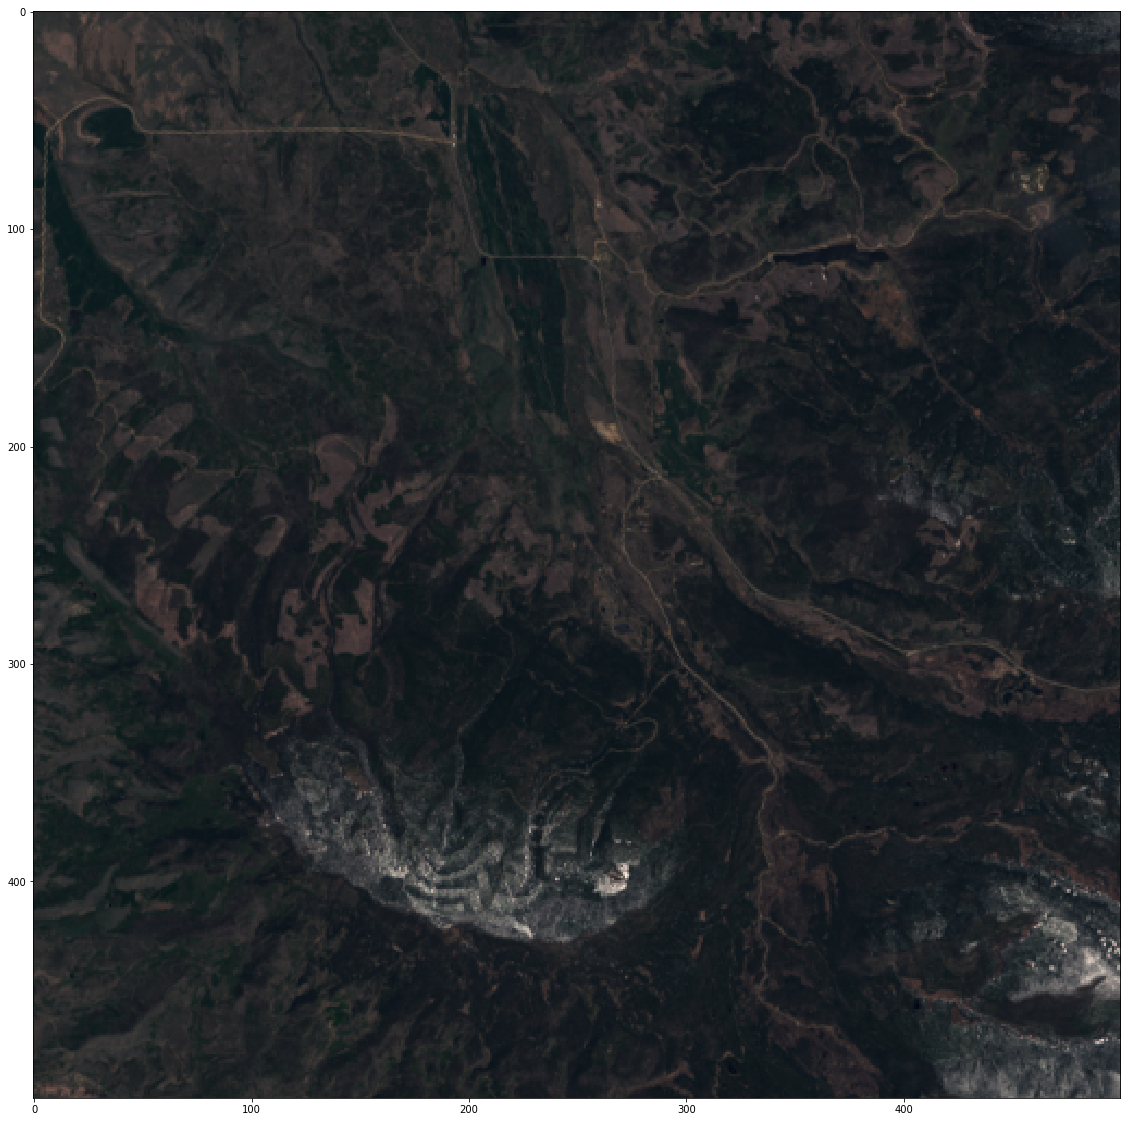

In [9]:
# slice the full array for RGB channels
rgb_arr = test_im[[3,2,1], :, :]
rgb_arr = np.rollaxis(rgb_arr, 0, 3) # need channel axis to be last for plotting
rgb_arr_ma = np.ma.masked_equal(rgb_arr, 0)

fig, ax = plt.subplots(figsize=(20,20))
plt.imshow(bytescale(rgb_arr))

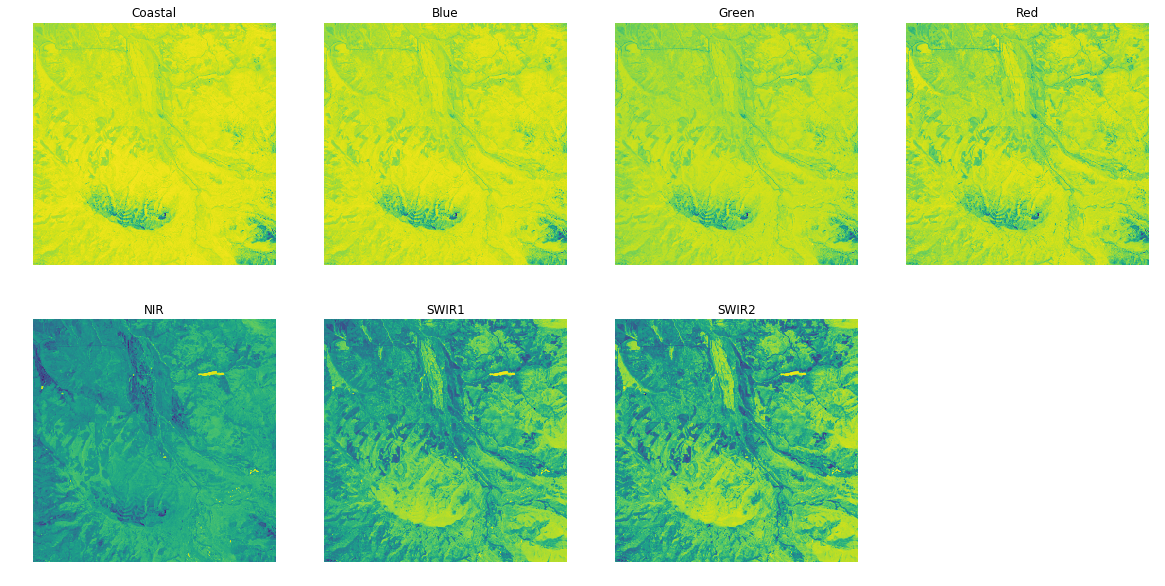

In [10]:
# plot the bands
plt.figure(figsize=(20,10))


channels = ['Coastal', 'Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2'] # used for plot titles
for i in range(test_im.shape[0]):
    plt.subplot(2,4,i+1)
    plt.axis('off')
    plot_band = np.ma.masked_equal(test_im[i], 0)
    plt.imshow(plot_band, cmap="viridis_r")
    plt.title(channels[i])
plt.show()




## Vegetation Index and Chromaticity

Normalized Difference Vegetation Index (NDVI) quantifies vegetation by measuring the difference between near-infrared (which vegetation strongly reflects) and red light (which vegetation absorbs). The equation we will be using to calculate NDVI is:

\begin{equation*}
NDVI = \frac{NIR - RED}{NIR + RED}
\end{equation*}


Chromaticity is an objective specification of the quality of a color regardless of its luminance. Here we specify the Blue, Green, Red, and NIR channels as colors to calculate their chromaticity.

\begin{equation*}
blue_{chromaticity} = \frac{BLUE}{BLUE + GREEN + RED + NIR}
\end{equation*}

\begin{equation*}
green_{chromaticity} = \frac{GREEN}{BLUE + GREEN + RED + NIR}
\end{equation*}

\begin{equation*}
red_{chromaticity} = \frac{RED}{BLUE + GREEN + RED + NIR}
\end{equation*}

\begin{equation*}
nir_{chromaticity} = \frac{NIR}{BLUE + GREEN + RED + NIR}
\end{equation*}

ndvi min/max: -0.12057314988195067 / 0.5804376578093062
c_red min/max: 0.1397812850504727 / 0.26552899779394334


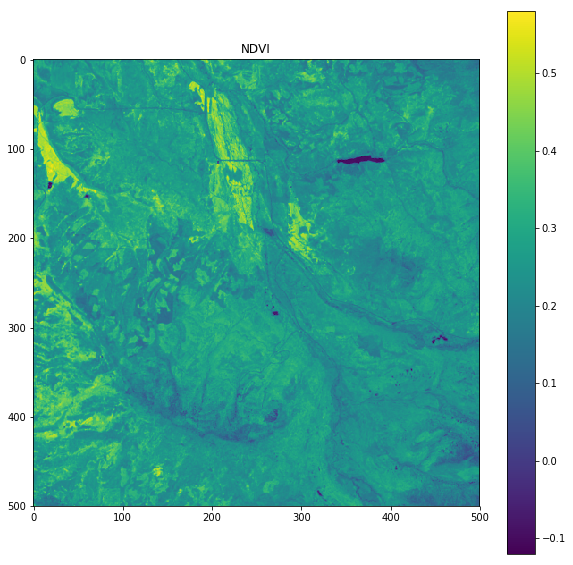

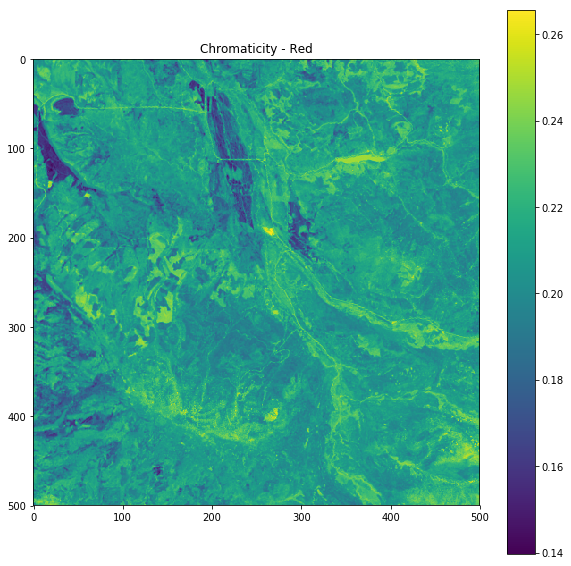

In [11]:
# subset the bands as necessary
blue = test_im[1,:,:].astype(np.float)
green = test_im[2,:,:].astype(np.float)
red = test_im[3,:,:].astype(np.float)
nir = test_im[4,:,:].astype(np.float)

# mask them
blue = np.ma.masked_equal(blue,0)
red = np.ma.masked_equal(red,0)
nir = np.ma.masked_equal(nir,0)

# define NDVI..  maybe look at some stats?
ndvi = (nir - red) / (nir + red)
print('ndvi min/max: {} / {}'.format(ndvi.min(), ndvi.max()))

# define a chromaticity coordinate..  maybe look at some stats?
c_red = red / (blue + green + red + nir)
print('c_red min/max: {} / {}'.format(c_red.min(), c_red.max()))

fig, ax = plt.subplots(figsize=(10,10))
cf = ax.imshow(ndvi) # change cmap
ax.set_title('NDVI')
fig.colorbar(cf, ax=ax)
plt.show()

fig, ax = plt.subplots(figsize=(10,10))
cf = ax.imshow(c_red) # change cmap
ax.set_title('Chromaticity - Red')
fig.colorbar(cf, ax=ax)

plt.show()


## use scikit learn for clustering on all 7 bands and then b/g/r/nir chromaticity bands. compare


C:\software\Anaconda3\envs\earth-analytics-python-2\lib\site-packages\ipykernel\__main__.py:23: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.


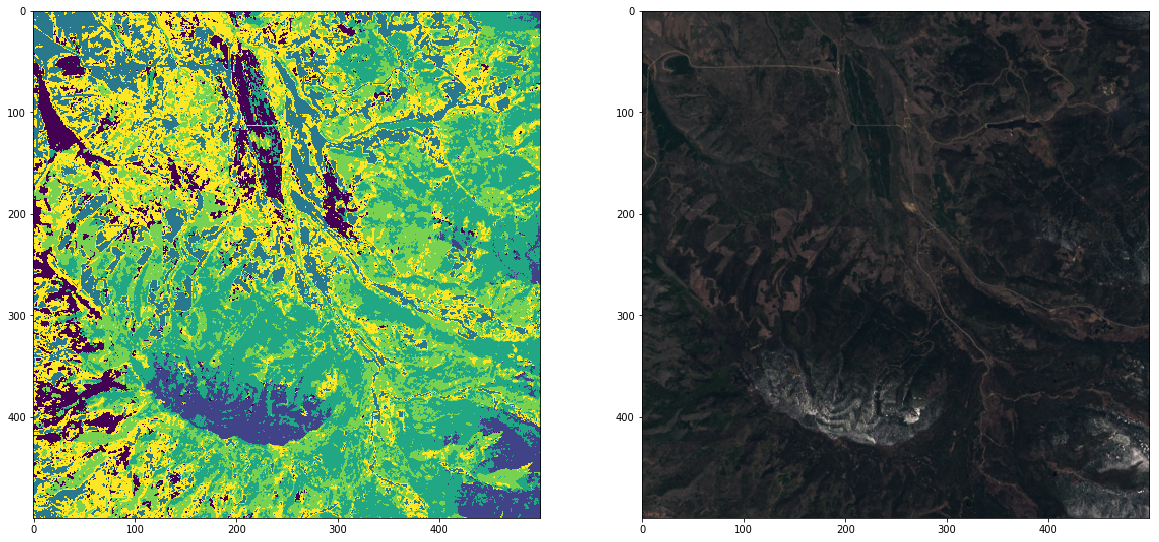

In [12]:
from sklearn.cluster import KMeans

# define number of clusters and create classifier
n_clusters = 6
clf = KMeans(n_clusters=n_clusters, random_state=0) # set a random state for similar results

## fit the K-means classifier on the 7 Landsat bands
# first reshape the array so channels are last axis. 
im_reshape = np.rollaxis(test_im, 0, 3).astype('float32')

# reshape again into columns for each channel
X = im_reshape.reshape(-1, im_reshape.shape[-1])

# fit the classifier
labels_test_im = clf.fit_predict(X, y=None)

# reshape the labels to the image size
labels_test_im_arr = np.reshape(labels_test_im, (test_im.shape[1], test_im.shape[2]))

## show the result
fig, ax = plt.subplots(1,2, figsize = (20, 20))
ax[0].imshow(labels_test_im_arr)
ax[1].imshow(bytescale(rgb_arr))
plt.show()

C:\software\Anaconda3\envs\earth-analytics-python-2\lib\site-packages\ipykernel\__main__.py:30: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.


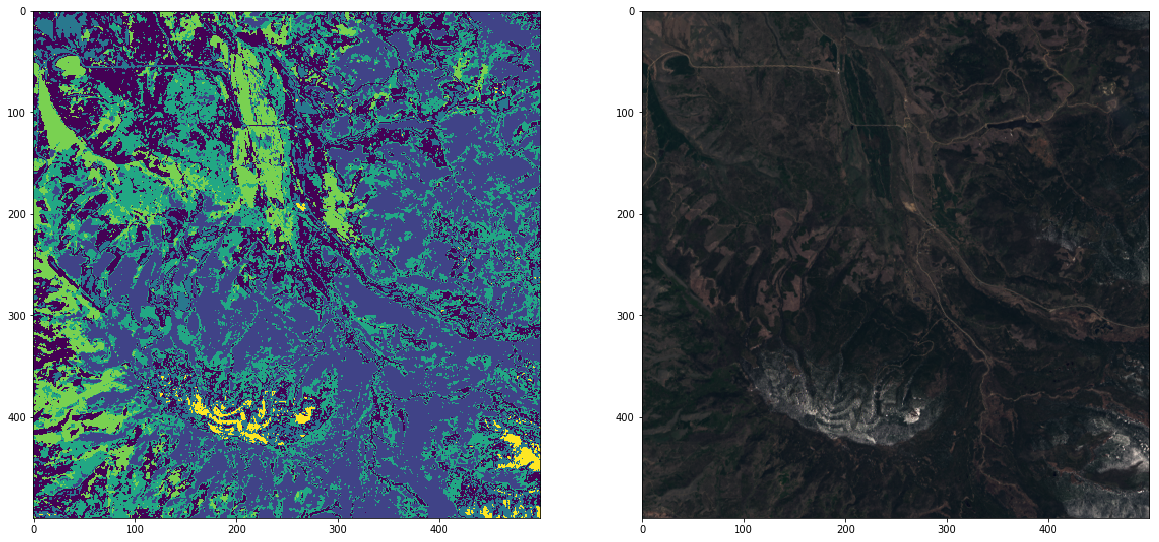

In [13]:
## look at it for chromaticity

# define number of clusters and create classifier
n_clusters = 6
clf = KMeans(n_clusters=n_clusters, random_state=0) # set a random state for similar results

## fit the K-means classifier on the 7 Landsat bands
# first reshape the array so channels are last axis. 
im_reshape = np.rollaxis(test_im, 0, 3).astype('float32')

# reshape again into columns for each channel
X = im_reshape.reshape(-1, im_reshape.shape[-1])

# use only the Blue/Green/Red/NIR channels
Xc = X[:, [1,2,3,4]]

# normalize by the sum to get chromaticity
Xc = Xc / Xc.sum(axis=0)


# fit the classifier
labels_test_chrom = clf.fit_predict(Xc, y=None)

# reshape the labels to the image size
labels_test_chrom_arr = np.reshape(labels_test_chrom, (test_im.shape[1], test_im.shape[2]))

## show the result
fig, ax = plt.subplots(1,2, figsize = (20, 20))
ax[0].imshow(labels_test_chrom_arr)
ax[1].imshow(bytescale(rgb_arr))
plt.show()

## Let's look for a Sentinel-2 scene over the same AOI
### the Sentinel-2 tile ID that intersects our AOI is 13TDE
### the date of the Landsat scene is 2018-05-26

In [25]:
!aws s3 ls sentinel-s2-l1c/tiles/13/T/DE/2018/6/1/0/
!aws s3 cp s3://sentinel-s2-l1c/tiles/13/T/DE/2018/6/1/0/preview.jpg preview.jpg

                           PRE auxiliary/
                           PRE preview/
                           PRE qi/
2018-06-03 17:23:09    3741370 B01.jp2
2018-06-03 17:23:09  120193431 B02.jp2
2018-06-03 17:23:09  122408932 B03.jp2
2018-06-03 17:23:09  128130153 B04.jp2
2018-06-03 17:23:09   33864002 B05.jp2
2018-06-03 17:23:09   33881459 B06.jp2
2018-06-03 17:23:09   33760005 B07.jp2
2018-06-03 17:23:09  135304008 B08.jp2
2018-06-03 17:23:09    3759616 B09.jp2
2018-06-03 17:23:09    2592374 B10.jp2
2018-06-03 17:23:09   33791633 B11.jp2
2018-06-03 17:23:09   33719782 B12.jp2
2018-06-03 17:23:09   33729799 B8A.jp2
2018-06-03 17:23:09  135027898 TCI.jp2
2018-06-03 17:23:09     630084 metadata.xml
2018-06-03 17:23:09     166469 preview.jp2
2018-06-03 17:23:38     124929 preview.jpg
2018-06-03 17:23:36       1031 productInfo.json
2018-06-03 17:23:09       1489 tileInfo.json
Completed 122.0 KiB/122.0 KiB (65.8 KiB/s) with 1 file(s) remaining
download: s3://sentinel-s2-l1c/tiles/13/T/DE/2

In [26]:
!mkdir sentinel2

In [45]:
import os

# copy the 10 meter bands, 2 3 4 8
sbands = [2,3,4,8]
aws_sent = 'sentinel-s2-l1c/tiles/13/T/DE/2018/5/17/0/'
for b in sbands:
    band = 'B0{}.jp2'.format(b)
    out_path = 'sentinel2/{}'.format(band)
    if not os.path.exists(out_path):
        !aws s3 cp s3://$aws_sent$band $out_path --no-sign-request


Completed 256.0 KiB/119.0 MiB (104.7 KiB/s) with 1 file(s) remaining
Completed 512.0 KiB/119.0 MiB (207.2 KiB/s) with 1 file(s) remaining
Completed 768.0 KiB/119.0 MiB (295.5 KiB/s) with 1 file(s) remaining
Completed 1.0 MiB/119.0 MiB (389.5 KiB/s) with 1 file(s) remaining  
Completed 1.2 MiB/119.0 MiB (462.6 KiB/s) with 1 file(s) remaining  
Completed 1.5 MiB/119.0 MiB (552.3 KiB/s) with 1 file(s) remaining  
Completed 1.8 MiB/119.0 MiB (643.7 KiB/s) with 1 file(s) remaining  
Completed 2.0 MiB/119.0 MiB (735.4 KiB/s) with 1 file(s) remaining  
Completed 2.2 MiB/119.0 MiB (827.0 KiB/s) with 1 file(s) remaining  
Completed 2.5 MiB/119.0 MiB (916.6 KiB/s) with 1 file(s) remaining  
Completed 2.8 MiB/119.0 MiB (899.7 KiB/s) with 1 file(s) remaining  
Completed 3.0 MiB/119.0 MiB (949.9 KiB/s) with 1 file(s) remaining  
Completed 3.2 MiB/119.0 MiB (1002.1 KiB/s) with 1 file(s) remaining 
Completed 3.5 MiB/119.0 MiB (1.0 MiB/s) with 1 file(s) remaining    
Completed 3.8 MiB/119.0 MiB (1.1 M

Completed 256.0 KiB/120.1 MiB (117.2 KiB/s) with 1 file(s) remaining
Completed 512.0 KiB/120.1 MiB (226.8 KiB/s) with 1 file(s) remaining
Completed 768.0 KiB/120.1 MiB (338.5 KiB/s) with 1 file(s) remaining
Completed 1.0 MiB/120.1 MiB (439.5 KiB/s) with 1 file(s) remaining  
Completed 1.2 MiB/120.1 MiB (547.0 KiB/s) with 1 file(s) remaining  
Completed 1.5 MiB/120.1 MiB (653.1 KiB/s) with 1 file(s) remaining  
Completed 1.8 MiB/120.1 MiB (738.4 KiB/s) with 1 file(s) remaining  
Completed 2.0 MiB/120.1 MiB (794.1 KiB/s) with 1 file(s) remaining  
Completed 2.2 MiB/120.1 MiB (890.6 KiB/s) with 1 file(s) remaining  
Completed 2.5 MiB/120.1 MiB (974.9 KiB/s) with 1 file(s) remaining  
Completed 2.8 MiB/120.1 MiB (1.0 MiB/s) with 1 file(s) remaining    
Completed 3.0 MiB/120.1 MiB (1.1 MiB/s) with 1 file(s) remaining    
Completed 3.2 MiB/120.1 MiB (1.1 MiB/s) with 1 file(s) remaining    
Completed 3.5 MiB/120.1 MiB (1.2 MiB/s) with 1 file(s) remaining    
Completed 3.8 MiB/120.1 MiB (1.3 M

Completed 256.0 KiB/124.6 MiB (119.1 KiB/s) with 1 file(s) remaining
Completed 512.0 KiB/124.6 MiB (226.7 KiB/s) with 1 file(s) remaining
Completed 768.0 KiB/124.6 MiB (332.3 KiB/s) with 1 file(s) remaining
Completed 1.0 MiB/124.6 MiB (442.1 KiB/s) with 1 file(s) remaining  
Completed 1.2 MiB/124.6 MiB (545.1 KiB/s) with 1 file(s) remaining  
Completed 1.5 MiB/124.6 MiB (636.6 KiB/s) with 1 file(s) remaining  
Completed 1.8 MiB/124.6 MiB (740.8 KiB/s) with 1 file(s) remaining  
Completed 2.0 MiB/124.6 MiB (841.8 KiB/s) with 1 file(s) remaining  
Completed 2.2 MiB/124.6 MiB (937.0 KiB/s) with 1 file(s) remaining  
Completed 2.5 MiB/124.6 MiB (1.0 MiB/s) with 1 file(s) remaining    
Completed 2.8 MiB/124.6 MiB (1.1 MiB/s) with 1 file(s) remaining    
Completed 3.0 MiB/124.6 MiB (1.1 MiB/s) with 1 file(s) remaining    
Completed 3.2 MiB/124.6 MiB (1.2 MiB/s) with 1 file(s) remaining    
Completed 3.5 MiB/124.6 MiB (1.2 MiB/s) with 1 file(s) remaining    
Completed 3.8 MiB/124.6 MiB (1.2 M

Completed 256.0 KiB/128.3 MiB (82.7 KiB/s) with 1 file(s) remaining
Completed 512.0 KiB/128.3 MiB (159.1 KiB/s) with 1 file(s) remaining
Completed 768.0 KiB/128.3 MiB (238.4 KiB/s) with 1 file(s) remaining
Completed 1.0 MiB/128.3 MiB (313.4 KiB/s) with 1 file(s) remaining  
Completed 1.2 MiB/128.3 MiB (388.5 KiB/s) with 1 file(s) remaining  
Completed 1.5 MiB/128.3 MiB (451.1 KiB/s) with 1 file(s) remaining  
Completed 1.8 MiB/128.3 MiB (523.2 KiB/s) with 1 file(s) remaining  
Completed 2.0 MiB/128.3 MiB (597.4 KiB/s) with 1 file(s) remaining  
Completed 2.2 MiB/128.3 MiB (622.0 KiB/s) with 1 file(s) remaining  
Completed 2.5 MiB/128.3 MiB (674.9 KiB/s) with 1 file(s) remaining  
Completed 2.8 MiB/128.3 MiB (740.5 KiB/s) with 1 file(s) remaining  
Completed 3.0 MiB/128.3 MiB (806.9 KiB/s) with 1 file(s) remaining  
Completed 3.2 MiB/128.3 MiB (853.3 KiB/s) with 1 file(s) remaining  
Completed 3.5 MiB/128.3 MiB (905.3 KiB/s) with 1 file(s) remaining  
Completed 3.8 MiB/128.3 MiB (966.8 

In [46]:
with rasterio.open(out_path) as src:
    print(src.meta, src.crs, src.bounds)

{'driver': 'JP2OpenJPEG', 'dtype': 'uint16', 'nodata': None, 'width': 10980, 'height': 10980, 'count': 1, 'crs': CRS({'init': 'epsg:32613'}), 'transform': (399960.0, 10.0, 0.0, 4500000.0, 0.0, -10.0), 'affine': Affine(10.0, 0.0, 399960.0,
       0.0, -10.0, 4500000.0)} CRS({'init': 'epsg:32613'}) BoundingBox(left=399960.0, bottom=4390200.0, right=509760.0, top=4500000.0)


In [47]:
import fiona
import rasterio
from rasterio.tools.mask import mask

with fiona.open("shp/aoi.shp", "r") as shapefile:
    geoms = [feature["geometry"] for feature in shapefile]

with rasterio.open(out_path) as src:
    out_image, out_transform = mask(src, geoms, crop=True)
    out_meta = src.meta.copy()


In [48]:
out_image.shape

(1, 1501, 1501)

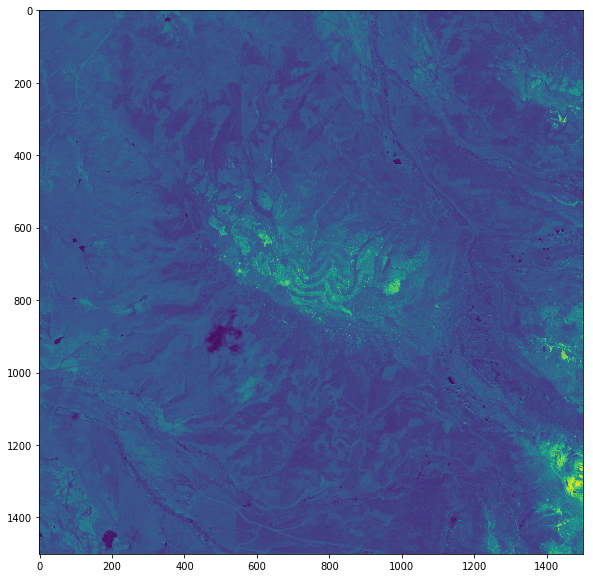

In [49]:
plt.figure(figsize=(10,10))
plt.imshow(out_image[0])